In [21]:
import h2o
from h2o.grid import H2OGridSearch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [40]:
h2o.init()
h2o.remove_all

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.1" 2019-10-15; Java(TM) SE Runtime Environment (build 13.0.1+9); Java HotSpot(TM) 64-Bit Server VM (build 13.0.1+9, mixed mode, sharing)
  Starting server from /Users/kessler.363/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/__/ws77c_4x71x589ltf4gpjsh59bl4wx/T/tmpa0yzp_as
  JVM stdout: /var/folders/__/ws77c_4x71x589ltf4gpjsh59bl4wx/T/tmpa0yzp_as/h2o_kessler_363_started_from_python.out
  JVM stderr: /var/folders/__/ws77c_4x71x589ltf4gpjsh59bl4wx/T/tmpa0yzp_as/h2o_kessler_363_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_kessler_363_b0z9kx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


<function h2o.h2o.remove_all(retained=None)>

In [77]:
df = h2o.import_file('h2oOneHot.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [78]:
features = df.columns[:df.columns.index('class')] + df.columns[df.columns.index('class')+1:]

In [79]:
feature_cols = features
response_col = 'class'

In [80]:
df['class'] = df['class'].asfactor()

In [81]:
train,valid = df.split_frame(ratios=[0.7],seed=333)


In [84]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

nFolds = 3

gbm = H2OGradientBoostingEstimator(nfolds = nFolds, fold_assignment = "Modulo",keep_cross_validation_predictions = True,

                                   min_rows = 4, ntrees = 50, max_depth = 3, learn_rate = 0.01, balance_classes=True,

                                   stopping_metric = 'AUC', stopping_rounds = 3, stopping_tolerance = 1e-4, score_tree_interval = 10, seed = 333)

gbm.train(x = feature_cols, y = response_col, training_frame = train,validation_frame=valid)
print(gbm.auc())
print(gbm.accuracy(train=True, valid=True, xval=False))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
0.86960587699835
{'train': [[0.5303055262883681, 0.8]], 'valid': [[0.49834806112502256, 0.7542662116040956]]}


In [85]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf = H2ORandomForestEstimator(nfolds = nFolds, fold_assignment = "Modulo",keep_cross_validation_predictions = True,

                                   min_rows = 4, ntrees = 100, max_depth = 6, balance_classes=True,

                                   stopping_metric = 'AUC', stopping_rounds = 3, stopping_tolerance = 1e-4, score_tree_interval = 10, seed = 333)

rf.train(x = feature_cols, y = response_col, training_frame = train,validation_frame=valid)

print(rf.auc())
print(rf.accuracy(train=True, valid=True, xval=False))

drf Model Build progress: |███████████████████████████████████████████████| 100%
0.8352641235705752
{'train': [[0.5614567177606857, 0.7706666666666667]], 'valid': [[0.5268493462648198, 0.7440273037542662]]}


In [87]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

# metaLearnerParams = {'balance_classes': 'True'}

ensemble = H2OStackedEnsembleEstimator(base_models=[gbm, rf],

                                       metalearner_algorithm = 'glm', # metalearner_params = metaLearnerParams,

                                       seed = 333)

ensemble.train(x = feature_cols, y = response_col, training_frame = train,validation_frame=valid)

print(ensemble.auc())
print(ensemble.accuracy(train=True, valid=True, xval=False))

stackedensemble Model Build progress: |███████████████████████████████████| 100%
0.9296507133319278
{'train': [[0.4683675203567977, 0.8525073746312685]], 'valid': [[0.5374806997550806, 0.7440273037542662]]}


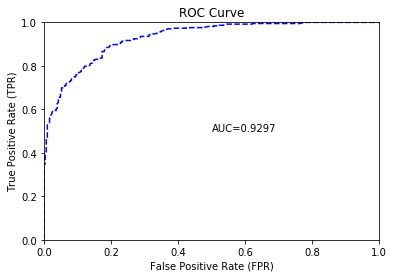

In [88]:
ensemble.model_performance().plot(type = "roc")

## OK the AUC is good but what does this mean for the prediction rate? 

In [89]:
finalPrediction = ensemble.predict(test[:-1])
testdf = test.concat(finalPrediction,axis=1)[['class','predict']].as_data_frame(use_pandas=True)
len(testdf[testdf['class'].values == testdf['predict'].values])/len(testdf)

stackedensemble prediction progress: |████████████████████████████████████| 100%


/Users/kessler.363/anaconda3/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column 'Zach Zarba': substituting in a column of NaN
  warnings.warn(w)


0.726962457337884

## The ensemble model gets it right 72% of the time for this data which we can def make money off of

In [90]:
ensemble.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4578058508471754: 


,,0,1,Error,Rate
0,0,245.0,61.0,0.1993,(61.0/306.0)
1,1,39.0,333.0,0.1048,(39.0/372.0)
2,Total,284.0,394.0,0.1475,(100.0/678.0)


In [91]:
from sklearn.metrics import confusion_matrix
labels = [0,1]
cm = confusion_matrix(testdf['class'].values, testdf['predict'].values)
print(cm)


[[ 85  46]
 [ 34 128]]


[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

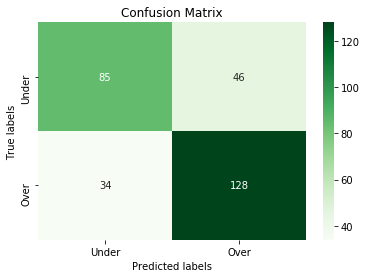

In [92]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap='Greens')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Under','Over'])
ax.yaxis.set_ticklabels(['Under','Over'])

In [137]:
h2o.cluster().shutdown()

H2O session _sid_a0bf closed.
